In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load in Data

In [154]:
data = pd.read_csv("../data/training_data_neck_cheek.csv")

In [114]:
# data = pd.read_csv("../data/training_data_neck_cheek.csv")
subject = 'Katie'
date = '7_26_EMG'

data = pd.DataFrame()
sfreq = 500

for i in [1, 2, 3]:
    # data_path = f'../../data/{date}/{subject}/Katie_7-23_EEG_no_OSCAR_{i}.csv'
    data_path = f'../data/{date}/{subject}/{subject.lower()}{i}emg-interject.csv'
    eeg = pd.read_csv(data_path)
    data = pd.concat([data, eeg])

In [155]:
data

,timestamp,elapsed Time (ms),button 0,button 1,raw EMG 0,raw EMG 1,bandpass EMG 0,bandpass EMG 1,bandpass EMG envelope 0,bandpass EMG envelope 1
0,1.708814e+09,223968.0,0.0,0.0,2.99,0.34,0.73,0.38,0.06,0.07
1,1.708814e+09,223985.0,0.0,0.0,3.99,1.34,0.95,0.72,0.06,0.07
2,1.708814e+09,224002.0,0.0,0.0,4.99,1.34,1.09,0.56,0.06,0.07
3,1.708814e+09,224019.0,0.0,0.0,3.99,1.34,0.38,0.36,0.06,0.07
4,1.708814e+09,224037.0,0.0,0.0,3.99,1.34,0.15,0.21,0.06,0.07
...,...,...,...,...,...,...,...,...,...,...
17272,1.708814e+09,523845.0,0.0,0.0,-0.01,0.34,0.09,0.24,0.03,0.06
17273,1.708814e+09,523863.0,0.0,0.0,-0.01,-0.66,0.05,-0.25,0.03,0.06
17274,1.708814e+09,523880.0,0.0,0.0,-0.01,0.34,0.03,0.14,0.03,0.06
17275,1.708814e+09,523898.0,0.0,0.0,-0.01,0.34,0.02,0.16,0.03,0.06


In [156]:
emg_data = data[['bandpass EMG 0', 'bandpass EMG 1']]
emg_data = emg_data.to_numpy()

button_data = data[['button 0', 'button 1']]
button_data = button_data.to_numpy()

# Data Visualization

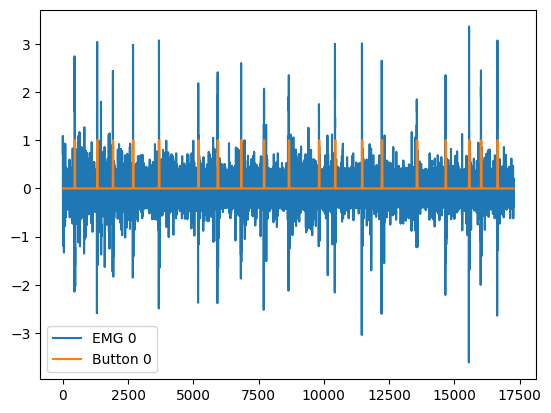

In [157]:
# Button 0 Press & Raw Bandpass EMG 0
fig, axs = plt.subplots()
axs.plot(emg_data[:, 0], label="EMG 0")
axs.plot(button_data[:, 0], label="Button 0")
axs.legend()

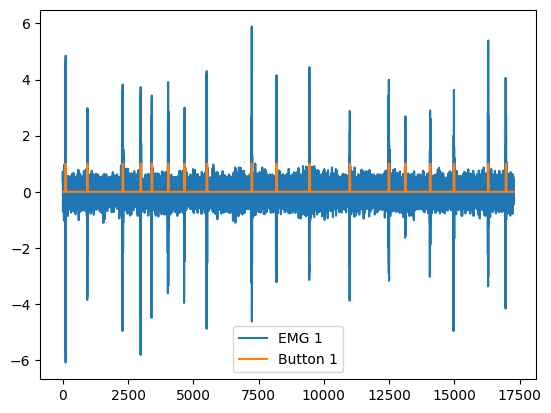

In [158]:
# Button 1 Press & Raw Bandpass EMG 1
fig, axs = plt.subplots()
axs.plot(emg_data[:, 1], label="EMG 1")
axs.plot(button_data[:, 1], label="Button 1")
axs.legend()

# Data Segmentation

In [85]:
# This is where we'll do the segmentation
# Overlapping windows with window increments less than the segment length

In [159]:
def create_overlapping_sliding_windows(data, window_size, overlap):
    windows = []
    for i in range(0, len(data) - window_size + 1, overlap):
        windows.append(data[i:i+window_size, :])
    return np.array(windows)

In [160]:
windowed_emg_data = create_overlapping_sliding_windows(emg_data, 100, 40)
windowed_button_labels = create_overlapping_sliding_windows(button_data, 100, 40)

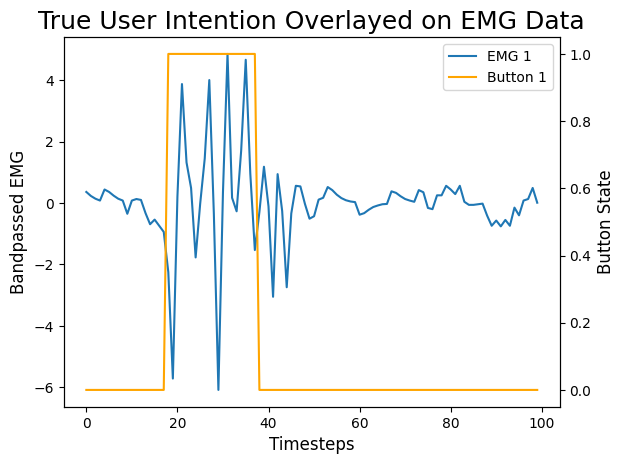

In [162]:
fig, axs = plt.subplots()

# Plot the first line on the first y-axis and set its label
line1 = axs.plot(windowed_emg_data[2, :, 1], label="EMG 1")
axs.set_ylabel('Bandpassed EMG', fontsize=12)

# Create a second y-axis and plot the second line on it
axs2 = axs.twinx()
line2 = axs2.plot(windowed_button_labels[2, :, 1], label="Button 1", color='orange')
axs2.set_ylabel('Button State', fontsize=12)


# Set the other labels and title
axs.set_xlabel('Timesteps', fontsize=12)
axs.set_title('True User Intention Overlayed on EMG Data', fontsize=18)

axs.plot()

# Create a legend for both lines
lines = line1 + line2
labels = [l.get_label() for l in lines]
axs.legend(lines, labels)

# Model Training

In [163]:
X = np.sqrt(np.mean(np.square(windowed_emg_data), axis=1))
y = np.max(windowed_button_labels, axis=1)

In [164]:
rms_EMG_0 = X[:,0].reshape(-1, 1)
button_0 = y[:, 0]

In [165]:
rms_EMG_1 = X[:,1].reshape(-1, 1)
button_1 = y[:, 1]

In [166]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

cv_results_0 = cross_validate(LogisticRegression(), rms_EMG_0, button_0, cv=5, scoring='accuracy', return_estimator=True)
cv_results_1 = cross_validate(LogisticRegression(), rms_EMG_1, button_1, cv=5, scoring='accuracy', return_estimator=True)

In [167]:
cv_results_0

{'fit_time': array([0.00295949, 0.00227094, 0.00214648, 0.0026269 , 0.00220394]),
 'score_time': array([0.00088406, 0.00076747, 0.00077915, 0.00081944, 0.00078297]),
 'estimator': [LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()],
 'test_score': array([0.98837209, 0.98837209, 0.93023256, 0.91860465, 0.96511628])}

In [168]:
cv_results_0['test_score'].mean()

0.9581395348837208

In [169]:
cv_results_1

{'fit_time': array([0.00290704, 0.00256944, 0.00236225, 0.00237441, 0.00226092]),
 'score_time': array([0.00078416, 0.00076127, 0.00081658, 0.00085497, 0.00069642]),
 'estimator': [LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()],
 'test_score': array([0.96511628, 0.97674419, 0.97674419, 0.95348837, 0.96511628])}

In [170]:
cv_results_1['test_score'].mean()

0.9674418604651163

In [171]:
emg_0_model = cv_results_0['estimator'][cv_results_0['test_score'].argmax()]

In [172]:
emg_1_model = cv_results_1['estimator'][cv_results_1['test_score'].argmax()]

Text(0, 0.5, 'Button Press')

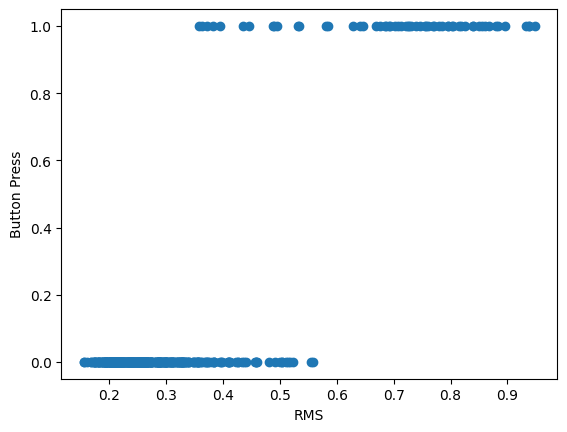

In [173]:
plt.scatter(rms_EMG_0, button_0)
plt.xlabel('RMS')
plt.ylabel('Button Press')

Text(0, 0.5, 'Button Press')

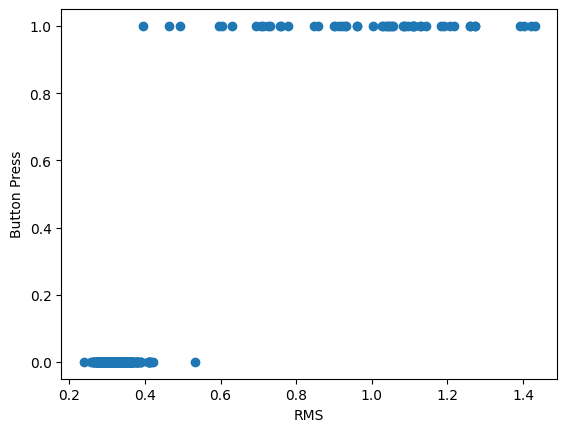

In [174]:
plt.scatter(rms_EMG_1, button_1)
plt.xlabel('RMS')
plt.ylabel('Button Press')

In [176]:
# import joblib

# joblib.dump(emg_0_model, '../saved_models/emg_0_model.pkl')
# joblib.dump(emg_1_model, '../saved_models/emg_1_model.pkl')

# Simulation of Predicting Realtime

In [177]:
import sys
sys.path.append('..')

from src.udp_processing_pipeline import BCIProcessingPipeline

pipeline = BCIProcessingPipeline(buffer_size=10)

In [178]:
sample_emg = windowed_emg_data[2,:,:]

In [179]:
predictions = []

for emg in sample_emg:
    predict_0, predict_1 = pipeline.predict(emg[0], emg[1])
    predictions.append(predict_1)

(array([64.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

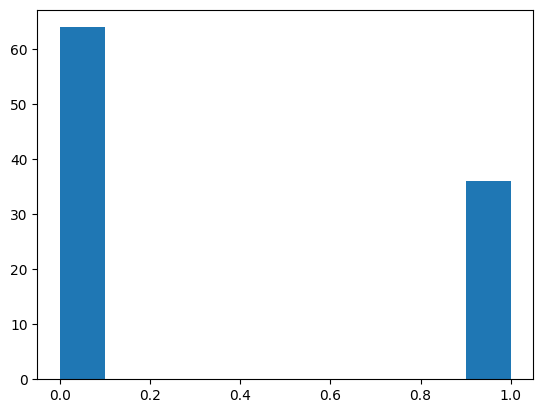

In [180]:
plt.hist(predictions)

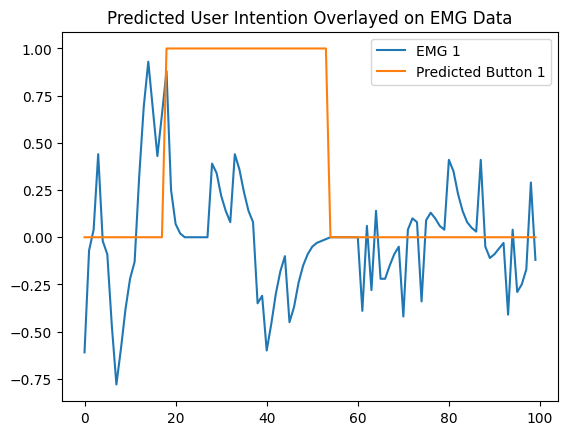

In [181]:
# Button 1 Press & Bandpass EMG 1
fig, axs = plt.subplots()
axs.plot(sample_emg[:, 0], label="EMG 1")
axs.plot(predictions[:], label="Predicted Button 1")
axs.set_title('Predicted User Intention Overlayed on EMG Data')
axs.legend()

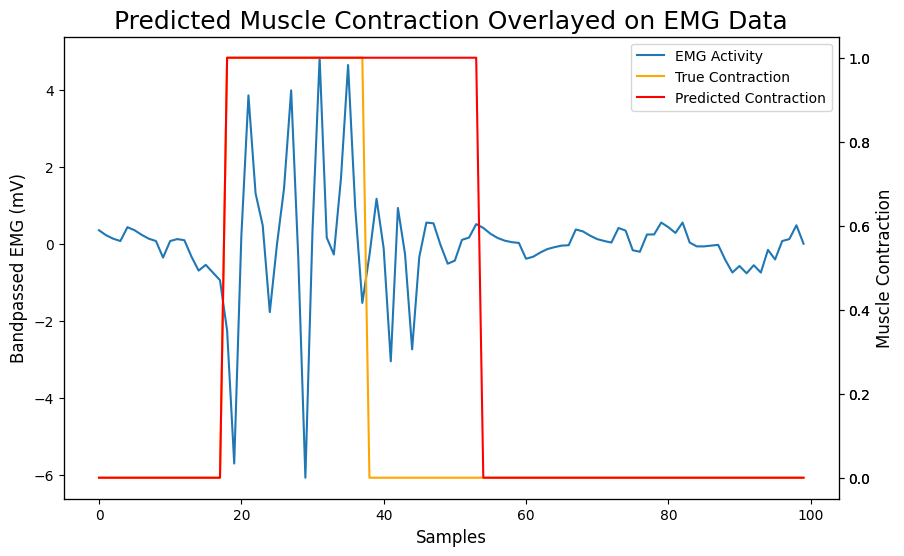

In [195]:
fig, axs = plt.subplots(figsize=(10, 6))

# Plot the first line on the first y-axis and set its label
line1 = axs.plot(sample_emg[:, 1], label="EMG Activity")
axs.set_ylabel('Bandpassed EMG (mV)', fontsize=12)

# Create a second y-axis and plot the second line on it
axs2 = axs.twinx()
line2 = axs2.plot(windowed_button_labels[2, :, 1], label="True Contraction", color='orange')
axs2.set_ylabel('Muscle Contraction', fontsize=12)

# Create a second y-axis and plot the second line on it
axs3 = axs.twinx()
line3 = axs3.plot(predictions[:], label="Predicted Contraction", color='red')

# Set the other labels and title
axs.set_xlabel('Samples', fontsize=12)
axs.set_title('Predicted Muscle Contraction Overlayed on EMG Data', fontsize=18)

# Create a legend for both lines
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
axs.legend(lines, labels)